![](https://storage.googleapis.com/kaggle-competitions/kaggle/47790/logos/header.png)

# Playground Series - Season 3, Episode 11
## *Tabular Regression with a Media Campaign Cost Dataset*

### **Welcome to the 2023 edition of Kaggle's Playground Series!**
Thank you to everyone who participated in and contributed to Season 3 Playground Series so far!

With the same goal to give the Kaggle community a variety of fairly light-weight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science, we will continue launching the Tabular Tuesday in March every Tuesday 00:00 UTC, with each competition running for 2 weeks. Again, these will be fairly light-weight datasets that are synthetically generated from real-world data, and will provide an opportunity to quickly iterate through various model and feature engineering ideas, create visualizations, etc..

### **Synthetically-Generated Datasets**
Using synthetic data for Playground competitions allows us to strike a balance between having real-world data (with named features) and ensuring test labels are not publicly available. This allows us to host competitions with more interesting datasets than in the past. While there are still challenges with synthetic data generation, the state-of-the-art is much better now than when we started the Tabular Playground Series two years ago, and that goal is to produce datasets that have far fewer artifacts. Please feel free to give us feedback on the datasets for the different competitions so that we can continue to improve!

#### Root Mean Squared Log Error (RMLSE)
Submissions are scored on the root mean squared log error (RMSLE) (the sklearn mean_squared_log_error with squared=False).

#### Submission File
For each id in the test set, you must predict the value for the target cost. The file should contain a header and have the following format:

```Python
id,cost
360336,99.615
360337,87.203
360338,101.111
etc.
```

**Start Date** - March 20, 2023

**Entry Deadline** - Same as the Final Submission Deadline

**Team Merger Deadline** - Same as the Final Submission Deadline

**Final Submission Deadline** - April 3, 2023

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

In [1]:
# 1 - import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingRegressor

In [2]:
# 2 - open training and test data
train = pd.read_csv('E:\Kaggle\Playground Series S3-E11\\train.csv')
test = pd.read_csv('E:\Kaggle\Playground Series S3-E11\\test.csv')
train.head(3)

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51


In [3]:
# 3 - display descriptive statistics of training data
train.describe()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
count,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000
mean,180167.500000,6.337376,3.043881,2.456482,0.689390,2.203813,13.822071,0.568086,0.327797,18.972706,28180.333442,0.564839,0.277394,0.504807,0.504832,0.503191,99.614729
std,104020.187637,3.307980,0.784676,1.488992,1.214732,1.084293,4.614792,0.495343,0.469411,10.212912,5968.874074,0.495779,0.447713,0.499978,0.499977,0.499991,29.939435
min,0.000000,0.510000,1.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,20319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.790000
25%,90083.750000,3.720000,3.000000,1.000000,0.000000,1.000000,9.710000,0.000000,0.000000,10.000000,23593.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.320000
50%,180167.500000,5.780000,3.000000,2.000000,0.000000,2.000000,13.600000,1.000000,0.000000,20.000000,27694.000000,1.000000,0.000000,1.000000,1.000000,1.000000,98.810000
75%,270251.250000,8.400000,4.000000,4.000000,1.000000,3.000000,17.700000,1.000000,1.000000,28.000000,33858.000000,1.000000,1.000000,1.000000,1.000000,1.000000,126.620000
max,360335.000000,22.920000,6.000000,5.000000,5.000000,4.000000,21.900000,1.000000,1.000000,36.000000,39696.000000,1.000000,1.000000,1.000000,1.000000,1.000000,149.750000


In [4]:
# 4 - look at the number of gaps in the training set
train.isna().sum()  # as you can see the number of passes is 0

id                            0
store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1    0
gross_weight                  0
recyclable_package            0
low_fat                       0
units_per_case                0
store_sqft                    0
coffee_bar                    0
video_store                   0
salad_bar                     0
prepared_food                 0
florist                       0
cost                          0
dtype: int64

In [5]:
# 5 - look at the number of gaps in the test set
test.isna().sum()  # as you can see the number of passes is 0

id                            0
store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1    0
gross_weight                  0
recyclable_package            0
low_fat                       0
units_per_case                0
store_sqft                    0
coffee_bar                    0
video_store                   0
salad_bar                     0
prepared_food                 0
florist                       0
dtype: int64

In [6]:
# 6 - look at the data type of the training set
train.info()  # all data is of type float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          360336 non-null  int64  
 1   store_sales(in millions)    360336 non-null  float64
 2   unit_sales(in millions)     360336 non-null  float64
 3   total_children              360336 non-null  float64
 4   num_children_at_home        360336 non-null  float64
 5   avg_cars_at home(approx).1  360336 non-null  float64
 6   gross_weight                360336 non-null  float64
 7   recyclable_package          360336 non-null  float64
 8   low_fat                     360336 non-null  float64
 9   units_per_case              360336 non-null  float64
 10  store_sqft                  360336 non-null  float64
 11  coffee_bar                  360336 non-null  float64
 12  video_store                 360336 non-null  float64
 13  salad_bar     

In [7]:
# 7 - look at the correlation between features
correlation = train.corr()
correlation.style.background_gradient(cmap='plasma')

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
id,1.000000,0.001750,0.000586,0.003260,0.001695,0.003257,0.001178,0.000276,0.000735,0.000496,0.000071,-0.001613,-0.002796,-0.002218,-0.002217,-0.003533,-0.000611
store_sales(in millions),0.001750,1.000000,0.481376,0.069303,0.029261,0.006794,0.038159,0.030390,-0.008735,-0.009893,0.021572,-0.040039,0.029564,0.044832,0.044854,0.046472,-0.012387
unit_sales(in millions),0.000586,0.481376,1.000000,0.113231,0.046755,0.017119,0.000467,0.001074,-0.003663,0.001141,0.045540,-0.076967,0.053795,0.082445,0.082485,0.083062,-0.026509
total_children,0.003260,0.069303,0.113231,1.000000,0.359207,0.078519,-0.000908,0.002236,-0.001597,-0.000267,-0.008991,-0.006476,-0.013303,-0.023564,-0.023560,-0.012545,-0.007482
num_children_at_home,0.001695,0.029261,0.046755,0.359207,1.000000,0.115476,-0.000601,0.006104,-0.000208,-0.004174,0.005785,-0.023234,-0.020738,-0.031109,-0.031050,-0.017888,-0.001727
avg_cars_at home(approx).1,0.003257,0.006794,0.017119,0.078519,0.115476,1.000000,-0.002267,0.004021,-0.001912,0.001190,-0.020032,-0.000441,0.012702,-0.013102,-0.013035,-0.004284,0.027098
gross_weight,0.001178,0.038159,0.000467,-0.000908,-0.000601,-0.002267,1.000000,0.059050,-0.033421,-0.017609,-0.000455,0.000835,-0.000845,0.002116,0.002155,0.000764,-0.000116
recyclable_package,0.000276,0.030390,0.001074,0.002236,0.006104,0.004021,0.059050,1.000000,-0.030025,-0.003028,-0.000343,0.004037,0.004129,0.004674,0.004672,0.004849,-0.001455
low_fat,0.000735,-0.008735,-0.003663,-0.001597,-0.000208,-0.001912,-0.033421,-0.030025,1.000000,0.030226,0.001972,0.002622,0.002893,0.005602,0.005567,0.005540,-0.001975
units_per_case,0.000496,-0.009893,0.001141,-0.000267,-0.004174,0.001190,-0.017609,-0.003028,0.030226,1.000000,0.002297,0.000828,0.000569,0.001698,0.001699,0.000556,0.000180


*Features salad_bar and prepared_food have a very high correlation (about 1). To avoid multicollinearity, remove the prepared_food* feature

In [8]:
# 8 - remove the feature 'prepared_food'
train.drop(columns='prepared_food', axis=1, inplace=True)
test.drop(columns='prepared_food', axis=1, inplace=True)

In [9]:
# 9 - checking the correlation after removing the feature 'prepared_food'
correlation = train.corr()
correlation.style.background_gradient(cmap='YlOrRd')

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,florist,cost
id,1.000000,0.001750,0.000586,0.003260,0.001695,0.003257,0.001178,0.000276,0.000735,0.000496,0.000071,-0.001613,-0.002796,-0.002218,-0.003533,-0.000611
store_sales(in millions),0.001750,1.000000,0.481376,0.069303,0.029261,0.006794,0.038159,0.030390,-0.008735,-0.009893,0.021572,-0.040039,0.029564,0.044832,0.046472,-0.012387
unit_sales(in millions),0.000586,0.481376,1.000000,0.113231,0.046755,0.017119,0.000467,0.001074,-0.003663,0.001141,0.045540,-0.076967,0.053795,0.082445,0.083062,-0.026509
total_children,0.003260,0.069303,0.113231,1.000000,0.359207,0.078519,-0.000908,0.002236,-0.001597,-0.000267,-0.008991,-0.006476,-0.013303,-0.023564,-0.012545,-0.007482
num_children_at_home,0.001695,0.029261,0.046755,0.359207,1.000000,0.115476,-0.000601,0.006104,-0.000208,-0.004174,0.005785,-0.023234,-0.020738,-0.031109,-0.017888,-0.001727
avg_cars_at home(approx).1,0.003257,0.006794,0.017119,0.078519,0.115476,1.000000,-0.002267,0.004021,-0.001912,0.001190,-0.020032,-0.000441,0.012702,-0.013102,-0.004284,0.027098
gross_weight,0.001178,0.038159,0.000467,-0.000908,-0.000601,-0.002267,1.000000,0.059050,-0.033421,-0.017609,-0.000455,0.000835,-0.000845,0.002116,0.000764,-0.000116
recyclable_package,0.000276,0.030390,0.001074,0.002236,0.006104,0.004021,0.059050,1.000000,-0.030025,-0.003028,-0.000343,0.004037,0.004129,0.004674,0.004849,-0.001455
low_fat,0.000735,-0.008735,-0.003663,-0.001597,-0.000208,-0.001912,-0.033421,-0.030025,1.000000,0.030226,0.001972,0.002622,0.002893,0.005602,0.005540,-0.001975
units_per_case,0.000496,-0.009893,0.001141,-0.000267,-0.004174,0.001190,-0.017609,-0.003028,0.030226,1.000000,0.002297,0.000828,0.000569,0.001698,0.000556,0.000180


*Features with a high correlation (more than 0.62) are no longer left*

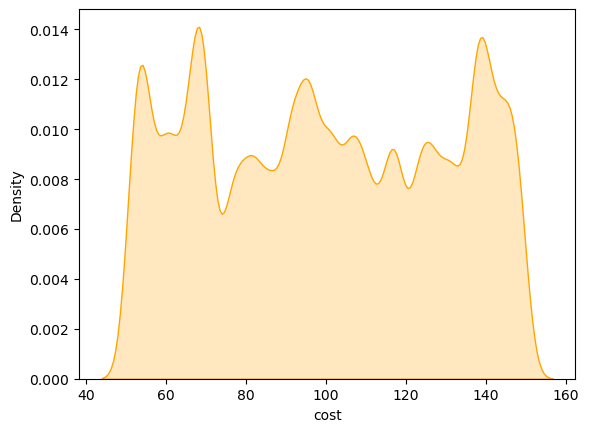

In [10]:
# 10 - look at the distribution of the dependent variable using kernel density estimation
sns.kdeplot(train.cost, fill=True, color='orange');

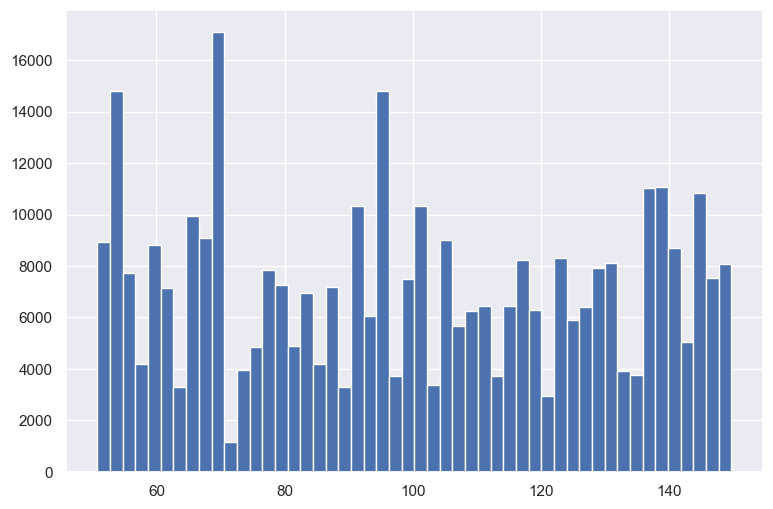

In [11]:
# 11 - look at the distribution of the dependent variable using a histogram of the distribution
sns.set(rc={'figure.figsize': (9, 6)})
train['cost'].hist(bins=50);

In [12]:
# 12 - use the Shapiro-Wilk test to check the distribution of 'cost' for normality
import scipy.stats as stats

result = stats.shapiro(train['cost'])
print(f'Shapiro-Wilk test statistic: {result[0]:.4f}')
print(f'p-value: {result[1]}')

Shapiro-Wilk test statistic: 0.9445
p-value: 0.0


E:\Multimedia\Anaconda\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


##### If p-value > 0.05, then we can accept the hypothesis of normal distribution. Otherwise, the hypothesis is rejected and the feature is not normally distributed.
###### In our case, the distribution is not normal, because p-value is 0.

In [13]:
#13 - To check if the distribution is normal, you can also use the Anderson-Darling test,
# which is more powerful than the Shapiro-Wilk test.
result = stats.anderson(train['cost'], dist='norm')
print(f'Anderson-Darling test statistic: {result[0]:.4f}')
print(f'critical values: {result[1]}')
print(f'Significance levels: {result[2]}')

Anderson-Darling test statistic: 5152.4337
critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]


##### If the value of the test statistic is less than the critical value, then the hypothesis of normal distribution can be accepted. If the value of the statistic is greater, then the hypothesis is rejected, and the feature is not normally distributed.

###### In our case, the distribution is not normal

In [14]:
# 14 - split the training dataset into X and y
X = train.drop(columns=['cost'], axis=1)
y = train.cost

In [15]:
# 15 - Standardizing data
sc = StandardScaler()
train_std = sc.fit_transform(X)  # first we train
test_std = sc.transform(test)

In [16]:
# 16 - train a Linear regression model and look at the metrics
lin_reg = LinearRegression().fit(train_std, y)
predict = lin_reg.predict(train_std)
print(f'mean_absolute_error: {mean_absolute_error(y, predict):.4f}')
print(f'mean_squared_error: {mean_squared_error(y, predict):.4f}')
print(f'mean_squared_log_error: {mean_squared_log_error(y, predict):.4f}')
print(f'r2_score: {r2_score(y, predict):.4f}')
predict

mean_absolute_error: 25.5729
mean_squared_error: 878.8631
mean_squared_log_error: 0.1004
r2_score: 0.0195


array([100.03612084, 104.53805476, 106.66293533, ...,  93.8980718 ,
        94.43673008,  98.09330408])

In [17]:
# 17 - train a XGB regression model and look at the metrics
xgb_reg = XGBRegressor().fit(train_std, y)
predict = xgb_reg.predict(train_std)
print(f'mean_absolute_error: {mean_absolute_error(y, predict):.4f}')
print(f'mean_squared_error: {mean_squared_error(y, predict):.4f}')
print(f'mean_squared_log_error: {mean_squared_log_error(y, predict):.4f}')
print(f'r2_score: {r2_score(y, predict):.4f}')
predict

mean_absolute_error: 23.7235
mean_squared_error: 773.9014
mean_squared_log_error: 0.0886
r2_score: 0.1366


array([ 74.6447  , 125.87242 ,  83.79418 , ..., 101.426796, 127.36822 ,
       112.14254 ], dtype=float32)

In [18]:
# 18 - initialize the models and train on the training set
model1 = LinearRegression()
model2 = CatBoostRegressor(random_state=42)
model3 = XGBRegressor(random_state=42)
model4 = LGBMRegressor(random_state=42)

model1.fit(train_std, y)
model2.fit(train_std, y)
model3.fit(train_std, y)
model4.fit(train_std, y)

# create an ensemble of models and predict on a test set
ensemble = StackingRegressor(regressors=[model1, model2, model3, model4],
                             meta_regressor=XGBRegressor(n_estimators=100, random_state=42))
ensemble.fit(train_std, y)

# evaluate the accuracy of predictions on a test set
predict = ensemble.predict(train_std)
print(f'mean_absolute_error: {mean_absolute_error(y, predict):.4f}')
print(f'mean_squared_error: {mean_squared_error(y, predict):.4f}')
print(f'mean_squared_log_error: {mean_squared_log_error(y, predict):.4f}')
print(f'r2_score: {r2_score(y, predict):.4f}')
predict

Learning rate set to 0.103786
0:	learn: 29.7839954	total: 227ms	remaining: 3m 46s
1:	learn: 29.6745473	total: 287ms	remaining: 2m 23s
2:	learn: 29.5730745	total: 337ms	remaining: 1m 52s
3:	learn: 29.4908186	total: 379ms	remaining: 1m 34s
4:	learn: 29.4187001	total: 419ms	remaining: 1m 23s
5:	learn: 29.3627770	total: 462ms	remaining: 1m 16s
6:	learn: 29.3191163	total: 525ms	remaining: 1m 14s
7:	learn: 29.2786016	total: 568ms	remaining: 1m 10s
8:	learn: 29.2451237	total: 611ms	remaining: 1m 7s
9:	learn: 29.2177272	total: 648ms	remaining: 1m 4s
10:	learn: 29.1948988	total: 687ms	remaining: 1m 1s
11:	learn: 29.1713418	total: 742ms	remaining: 1m 1s
12:	learn: 29.1511088	total: 786ms	remaining: 59.7s
13:	learn: 29.1349994	total: 820ms	remaining: 57.7s
14:	learn: 29.1158154	total: 853ms	remaining: 56s
15:	learn: 29.1039407	total: 886ms	remaining: 54.5s
16:	learn: 29.0760589	total: 923ms	remaining: 53.4s
17:	learn: 29.0544903	total: 971ms	remaining: 53s
18:	learn: 29.0389620	total: 1.01s	remai

array([ 72.434586, 136.35092 ,  72.802185, ...,  96.73985 , 143.10036 ,
       136.74374 ], dtype=float32)

In [19]:
# 19 - train a Catboost regression model and look at the metrics
cat = CatBoostRegressor()
cat.fit(train_std, y)
predict = cat.predict(train_std)
print(f'mean_absolute_error: {mean_absolute_error(y, predict):.4f}')
print(f'mean_squared_error: {mean_squared_error(y, predict):.4f}')
print(f'mean_squared_log_error: {mean_squared_log_error(y, predict):.4f}')
print(f'r2_score: {r2_score(y, predict):.4f}')
predict

Learning rate set to 0.103786
0:	learn: 29.7994427	total: 42.8ms	remaining: 42.8s
1:	learn: 29.6705341	total: 87.3ms	remaining: 43.6s
2:	learn: 29.5665711	total: 132ms	remaining: 43.7s
3:	learn: 29.4854790	total: 174ms	remaining: 43.3s
4:	learn: 29.4203161	total: 215ms	remaining: 42.8s
5:	learn: 29.3709659	total: 255ms	remaining: 42.2s
6:	learn: 29.3228398	total: 296ms	remaining: 42s
7:	learn: 29.2768378	total: 341ms	remaining: 42.3s
8:	learn: 29.2433435	total: 395ms	remaining: 43.5s
9:	learn: 29.2126386	total: 451ms	remaining: 44.6s
10:	learn: 29.1867699	total: 496ms	remaining: 44.6s
11:	learn: 29.1679499	total: 537ms	remaining: 44.2s
12:	learn: 29.1371824	total: 589ms	remaining: 44.7s
13:	learn: 29.1161038	total: 640ms	remaining: 45.1s
14:	learn: 29.0977035	total: 697ms	remaining: 45.8s
15:	learn: 29.0837197	total: 768ms	remaining: 47.2s
16:	learn: 29.0706657	total: 842ms	remaining: 48.7s
17:	learn: 29.0510382	total: 912ms	remaining: 49.8s
18:	learn: 29.0339154	total: 962ms	remaining

array([102.3145414 , 105.42275095,  96.47928547, ..., 103.47526443,
       106.01726039,  98.39160997])

In [21]:
# 20 - the best submit result was shown by the catboost model. Let's train a test sample on it
cat = CatBoostRegressor()
cat.fit(train_std, y)
cat_predict = cat.predict(test_std)
cat_predict

Learning rate set to 0.103786
0:	learn: 29.7994427	total: 34.1ms	remaining: 34s
1:	learn: 29.6705341	total: 66ms	remaining: 32.9s
2:	learn: 29.5665711	total: 97ms	remaining: 32.2s
3:	learn: 29.4854790	total: 128ms	remaining: 31.8s
4:	learn: 29.4203161	total: 157ms	remaining: 31.3s
5:	learn: 29.3709659	total: 190ms	remaining: 31.5s
6:	learn: 29.3228398	total: 236ms	remaining: 33.4s
7:	learn: 29.2768378	total: 270ms	remaining: 33.5s
8:	learn: 29.2433435	total: 301ms	remaining: 33.2s
9:	learn: 29.2126386	total: 331ms	remaining: 32.7s
10:	learn: 29.1867699	total: 361ms	remaining: 32.5s
11:	learn: 29.1679499	total: 391ms	remaining: 32.2s
12:	learn: 29.1371824	total: 428ms	remaining: 32.5s
13:	learn: 29.1161038	total: 474ms	remaining: 33.4s
14:	learn: 29.0977035	total: 507ms	remaining: 33.3s
15:	learn: 29.0837197	total: 542ms	remaining: 33.4s
16:	learn: 29.0706657	total: 573ms	remaining: 33.1s
17:	learn: 29.0510382	total: 600ms	remaining: 32.8s
18:	learn: 29.0339154	total: 630ms	remaining: 3

array([ 94.38187758,  99.9469161 ,  96.90659663, ...,  99.64445668,
       108.81735444, 102.78023017])

In [22]:
# 21 - making submission's dataset
submission = pd.DataFrame()
submission['id'] = test.id
submission['cost'] = cat_predict
submission

,id,cost
0,360336,94.381878
1,360337,99.946916
2,360338,96.906597
3,360339,115.341202
4,360340,85.122018
...,...,...
240219,600555,102.615254
240220,600556,91.672552
240221,600557,99.644457
240222,600558,108.817354


In [23]:
# 22 - making submission's csv file
submission[['id', 'cost']].to_csv('CatReg submission PSs3e11.csv', index=False)